In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

### Initial Conditions

In [2]:
# delta time (timestep)
dt = 1
# Number of time steps
ndt = 400
# Length
L = 1
# Number of grids == number of nodes-1
ndx = 2
ndy = 2
m = ndx*ndy
dx = 600
dy = 600
h = 40
# Static rock properties
phi = 0.27
kx = 500
ky = 500
Vb = dx*dy*h
cp = 0
# fluid properties
mu = 4
rho = 37
FVF = 1
betha_c = 0.001127
cf = 0
alpha_c = 5.614583

T = betha_c*dy*h*kx/(mu*FVF*dx)

RHS = (Vb*phi*(cf+cp))/(alpha_c*FVF*dt)

### Functions

In [3]:
ij_to_m = lambda i, j: (j-1)*ndx+i # convert poisition to m

In [4]:
ijpy_to_m = lambda i, j: (j)*ndx+i+1 # convert pythonic position (index starts from zero) to m

In [5]:
# list of all coordinations (i,j) and m
ijpy_m = []
for j in range(ndy):
    for i in range(ndx):
        ijpy_m.append(( (i, j), ijpy_to_m(i, j)))

In [6]:
# Check whether the block is a boundary grid block
def is_exterior(i, j):
    if i==0 or i==ndx-1 or j==0 or j==ndy-1:
        return True
    else:
        return False

In [7]:
# Check whether the block is inactive
def is_active(i, j):
    if i<0 or i>=ndx or j<0 or j>=ndy:
        return False
    else:
        return True

### No-flow Boundary Condition

In [187]:
tolerance = 1e-4
pi = 4000 # Initial Pressure
ndt = 100
all_A = []
pressure_grid = np.ones([ndx, ndy, ndt]) * pi
# well_coords = (1,1)
well_coords_inj = [(0,0), (20,20), (0,20), (20,0)]
well_coords_prod = (5,5)
# Create matrix A
A_m = np.zeros([m,m])
betha = np.zeros([m])
for t in range(ndt-1):
    A_m = np.zeros([m,m])
    betha = np.zeros([m])
    for n in range(m):
        i,j = ijpy_m[n][0]
        # term for neighboring blocks pressures
        if is_active(i-1, j):
            A_m[n, ijpy_to_m(i-1, j)-1] = -T

        if is_active(i, j-1):
            A_m[n, ijpy_to_m(i, j-1)-1] = -T

        if is_active(i+1, j):
            A_m[n, ijpy_to_m(i+1, j)-1] = -T

        if is_active(i, j+1):
            A_m[n, ijpy_to_m(i, j+1)-1] = -T
        
        A_m[n, n] = RHS + 4*T
        
        if is_exterior(i, j):
            if i==0:
                A_m[n, n] -= T
            if i==ndx-1:
                A_m[n, n] -= T
            if j==0:
                A_m[n, n] -= T
            if j==ndy-1:
                A_m[n, n] -= T
        betha[n] = RHS*pressure_grid[i, j, t]
    # Well source
    # betha[ijpy_to_m(*well_coords_inj[0])-1] += 5000
    # betha[ijpy_to_m(*well_coords_inj[1])-1] += 5000
    # betha[ijpy_to_m(*well_coords_inj[2])-1] += 5000
    # betha[ijpy_to_m(*well_coords_inj[3])-1] += 5000
    betha[ijpy_to_m(*well_coords_prod)-1] -= 4000
    if t==0:
        betha_zero = betha
    p = np.linalg.solve(A_m, betha)
    all_A.append(A_m)
    pressure_grid[:,:,t+1] = p.reshape(ndx, ndy, order='F').copy()
noflow_pgrid = pressure_grid.copy()

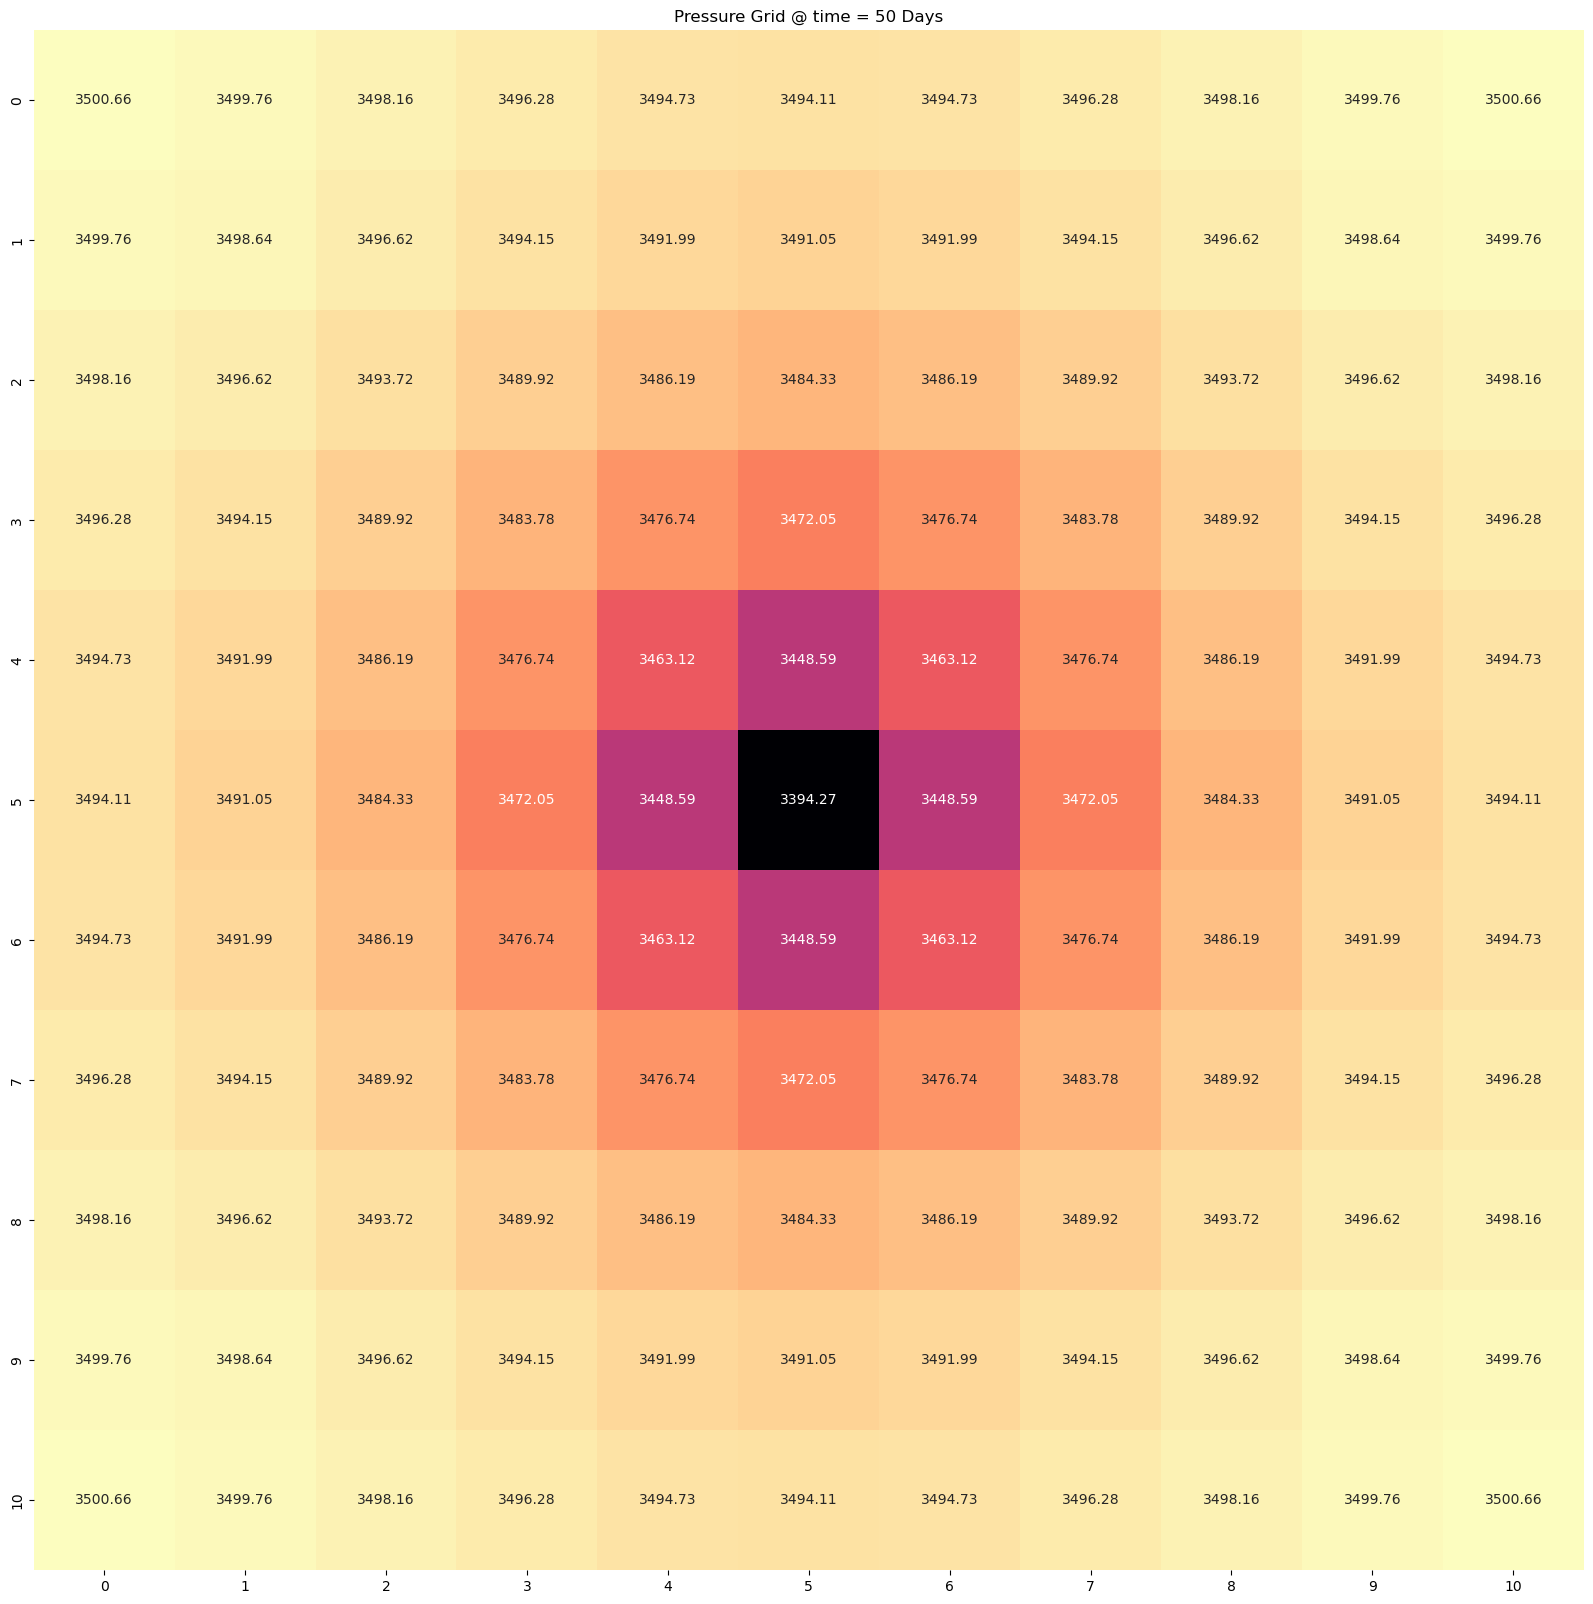

In [188]:
labels = [i+1 for i in range(len(ijpy_m))]
labels = np.reshape(labels, (ndy, ndx))
time = 50
labels = pressure_grid[:,:,time].reshape(ndy, ndx)
plt.figure(figsize=(20,20))
ax = sns.heatmap(pressure_grid[:,:,time].swapaxes(0, 1), cmap="magma", cbar=False, annot=True, fmt='.2f')
ax.set()
ax.set_title(f'Pressure Grid @ time = {time} Days')
plt.show()


Text(0.5, 0, 'Time (days)')

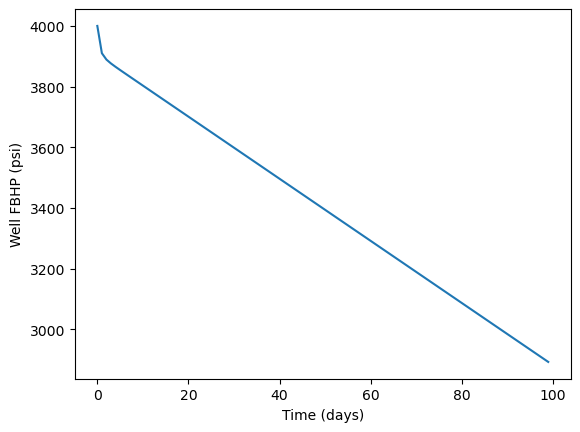

In [128]:
plt.plot(pressure_grid[5,5,:])
plt.ylabel('Well FBHP (psi)')
plt.xlabel('Time (days)')

### Constant Pressure Gradient Boundary

In [189]:
tolerance = 1e-4
pi = 4000
ndt = 100
all_A = []
pressure_grid = np.ones([ndx, ndy, ndt]) * pi
# well_coords = (1,1)
# well_coords_inj = [(1,1)]
wells_coords_prod = [(5,5)]
# Create matrix A
A_m = np.zeros([m,m])
betha = np.zeros([m])
for t in range(ndt-1):
    A_m = np.zeros([m,m])
    betha = np.zeros([m])
    for n in range(m):
        i,j = ijpy_m[n][0]
        # term for neighboring blocks pressures
        if is_active(i-1, j):
            A_m[n, ijpy_to_m(i-1, j)-1] = -T

        if is_active(i, j-1):
            A_m[n, ijpy_to_m(i, j-1)-1] = -T

        if is_active(i+1, j):
            A_m[n, ijpy_to_m(i+1, j)-1] = -T

        if is_active(i, j+1):
            A_m[n, ijpy_to_m(i, j+1)-1] = -T
        
        A_m[n, n] = RHS + 4*T
        
        if is_exterior(i, j):
            if i==0:
                A_m[n, n] -= T
            if i==ndx-1:
                A_m[n, n] -= T
            if j==0:
                A_m[n, n] -= T
            if j==ndy-1:
                A_m[n, n] -= T
        betha[n] = RHS*pressure_grid[i, j, t]
        # Constant Pressure Gradient : T*dp
        if is_exterior(i, j):
            if i==0:
                betha[n] += T*2
            if i==ndx-1:
                betha[n] += T*2
            if j==0:
                betha[n] += T*2
            if j==ndy-1:
                betha[n] += T*2
    # Well source
    for well in wells_coords_prod:
        betha[ijpy_to_m(*well)-1] -= 4000
    if t==0:
        betha_zero = betha
    p = np.linalg.solve(A_m, betha)
    all_A.append(A_m)
    pressure_grid[:,:,t+1] = p.reshape(ndx, ndy, order='F').copy()
cpg_pgrid = pressure_grid.copy()

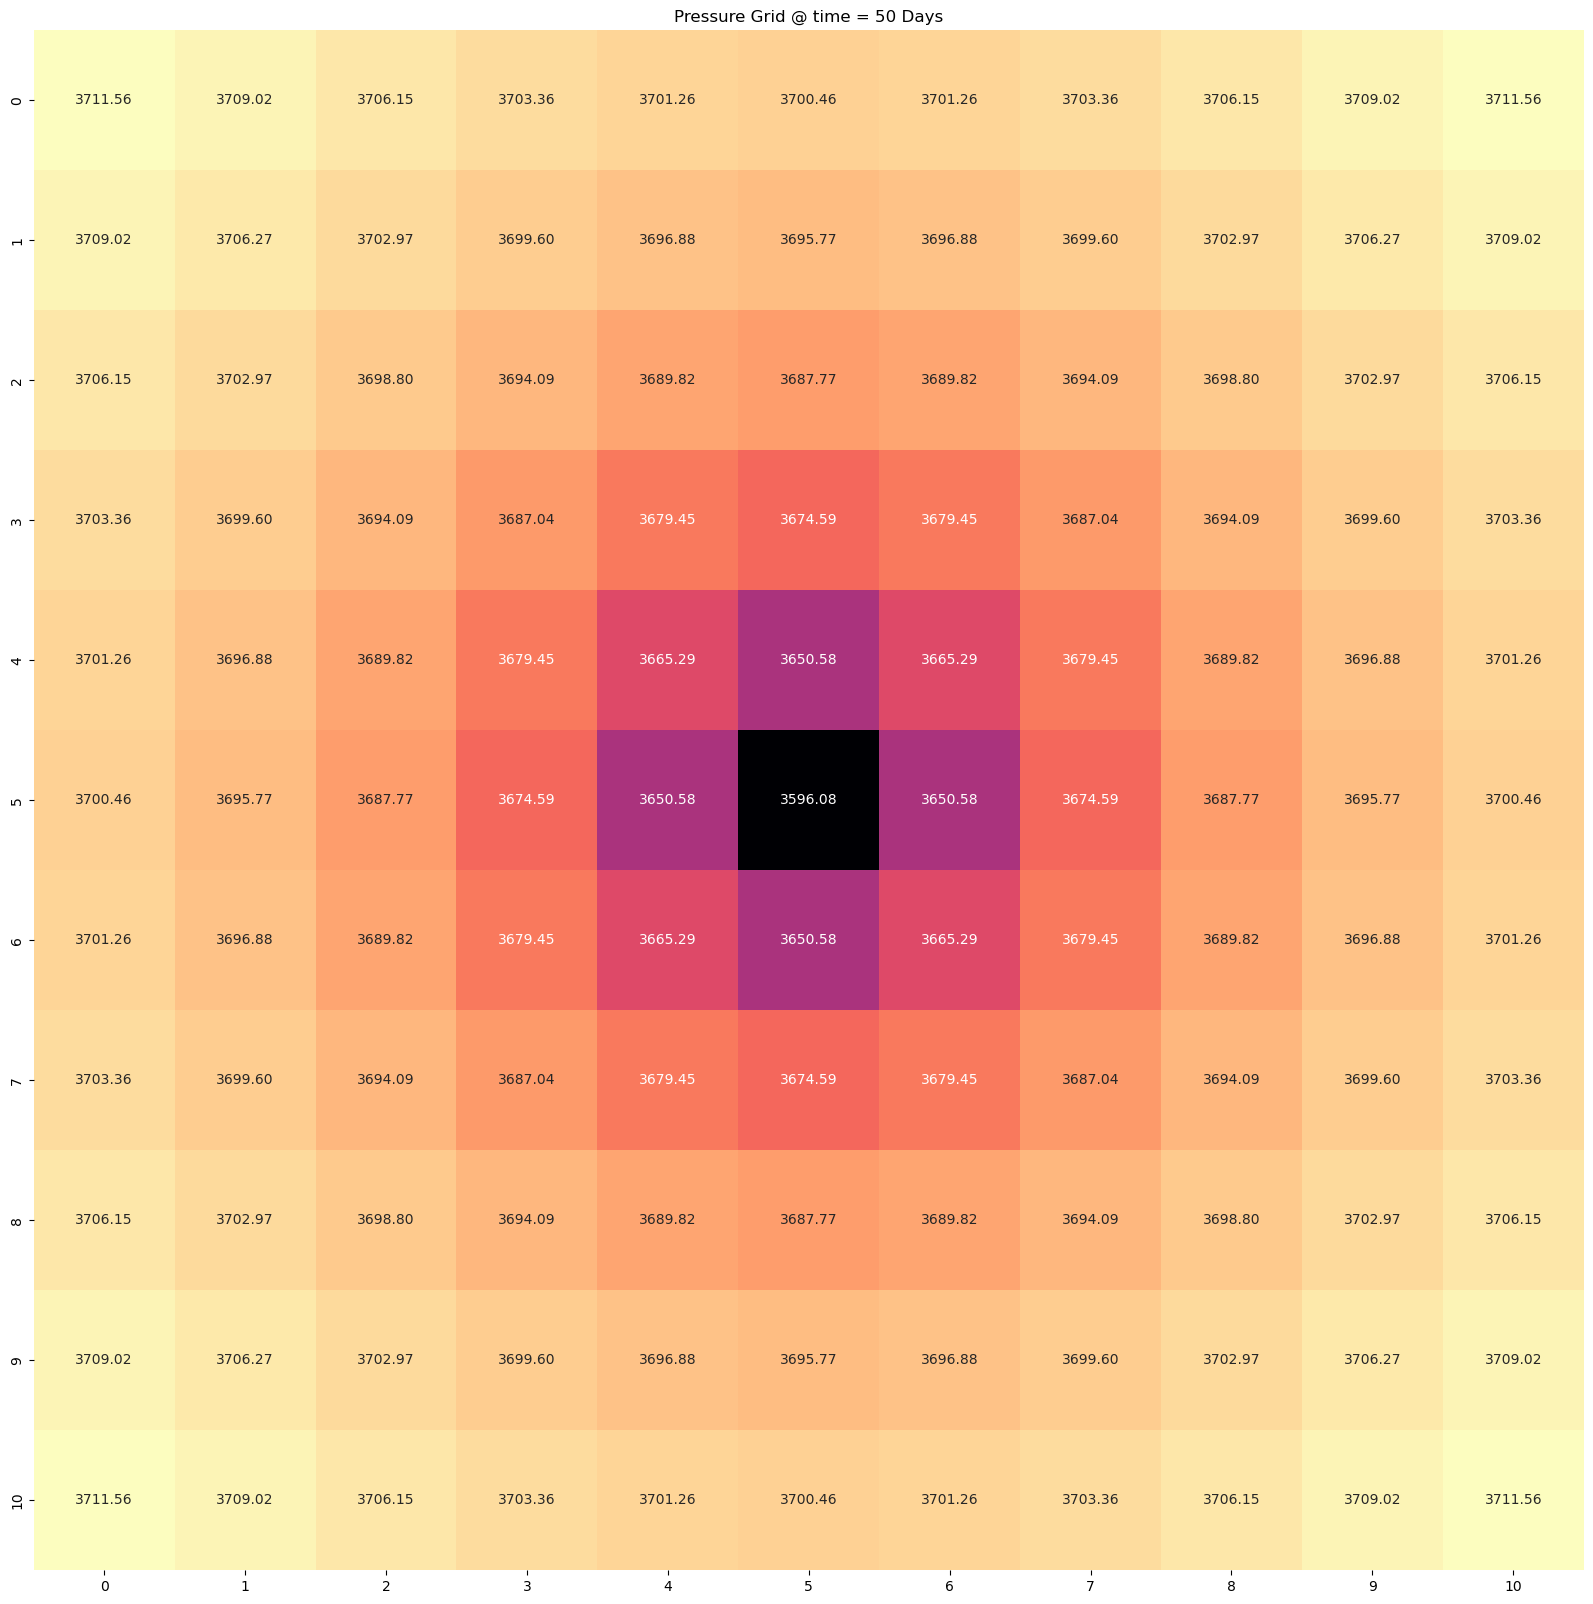

In [152]:
labels = [i+1 for i in range(len(ijpy_m))]
labels = np.reshape(labels, (ndy, ndx))
time = 50
labels = pressure_grid[:,:,time].reshape(ndy, ndx)
plt.figure(figsize=(20,20))
ax = sns.heatmap(pressure_grid[:,:,time].swapaxes(0, 1), cmap="magma", cbar=False, annot=True, fmt='.2f')
ax.set()
ax.set_title(f'Pressure Grid @ time = {time} Days')
plt.show()


Text(0.5, 0, 'Time (days)')

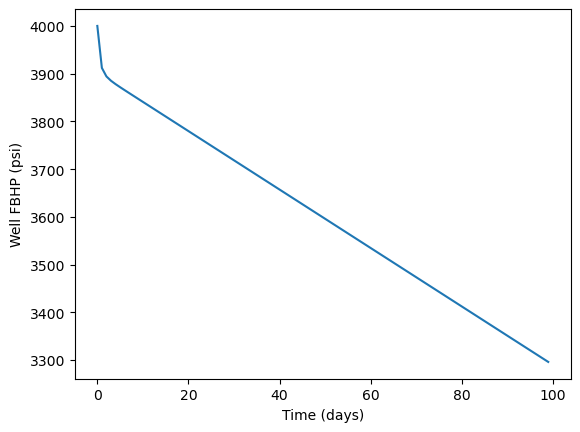

In [153]:
plt.plot(pressure_grid[5,5,:])
plt.ylabel('Well FBHP (psi)')
plt.xlabel('Time (days)')

### Constant Pressure Boundary

In [192]:
tolerance = 1e-4
pi = 4000
ndt = 400
all_A = []
pressure_grid = np.ones([ndx, ndy, ndt]) * pi
# well_coords = (1,1)
# well_coords_inj = [(1,1)]
wells_coords_prod = [(5,5)]
# Create matrix A
A_m = np.zeros([m,m])
betha = np.zeros([m])
for t in range(ndt-1):
    A_m = np.zeros([m,m])
    betha = np.zeros([m])
    for n in range(m):
        i,j = ijpy_m[n][0]
        # term for neighboring blocks pressures
        if is_active(i-1, j):
            A_m[n, ijpy_to_m(i-1, j)-1] = -T

        if is_active(i, j-1):
            A_m[n, ijpy_to_m(i, j-1)-1] = -T

        if is_active(i+1, j):
            A_m[n, ijpy_to_m(i+1, j)-1] = -T

        if is_active(i, j+1):
            A_m[n, ijpy_to_m(i, j+1)-1] = -T
        
        A_m[n, n] = RHS + 4*T
        
        if is_exterior(i, j):
            if i==0:
                A_m[n, n] -= T
            if i==ndx-1:
                A_m[n, n] -= T
            if j==0:
                A_m[n, n] -= T
            if j==ndy-1:
                A_m[n, n] -= T
        betha[n] = RHS*pressure_grid[i, j, t]
        # Constant Pressure Boundary : T*(p_grid - p_boundary)
        const_p = 4000
        if is_exterior(i, j):
            if i==0 and const_p>pressure_grid[i, j, t]:
                betha[n] -= T*(pressure_grid[i, j, t] - const_p)*2
            if i==ndx-1 and const_p>pressure_grid[i, j, t]:
                betha[n] -= T*(pressure_grid[i, j, t] - const_p)*2
            if j==0 and const_p>pressure_grid[i, j, t]:
                betha[n] -= T*(pressure_grid[i, j, t] - const_p)*2
            if j==ndy-1 and const_p>pressure_grid[i, j, t]:
                betha[n] -= T*(pressure_grid[i, j, t] - const_p)*2
    # Well source
    for well in wells_coords_prod:
        betha[ijpy_to_m(*well)-1] -= 20000
    if t==0:
        betha_zero = betha
    p = np.linalg.solve(A_m, betha)
    all_A.append(A_m)
    pressure_grid[:,:,t+1] = p.reshape(ndx, ndy, order='F').copy()
cp_pgrid = pressure_grid.copy()

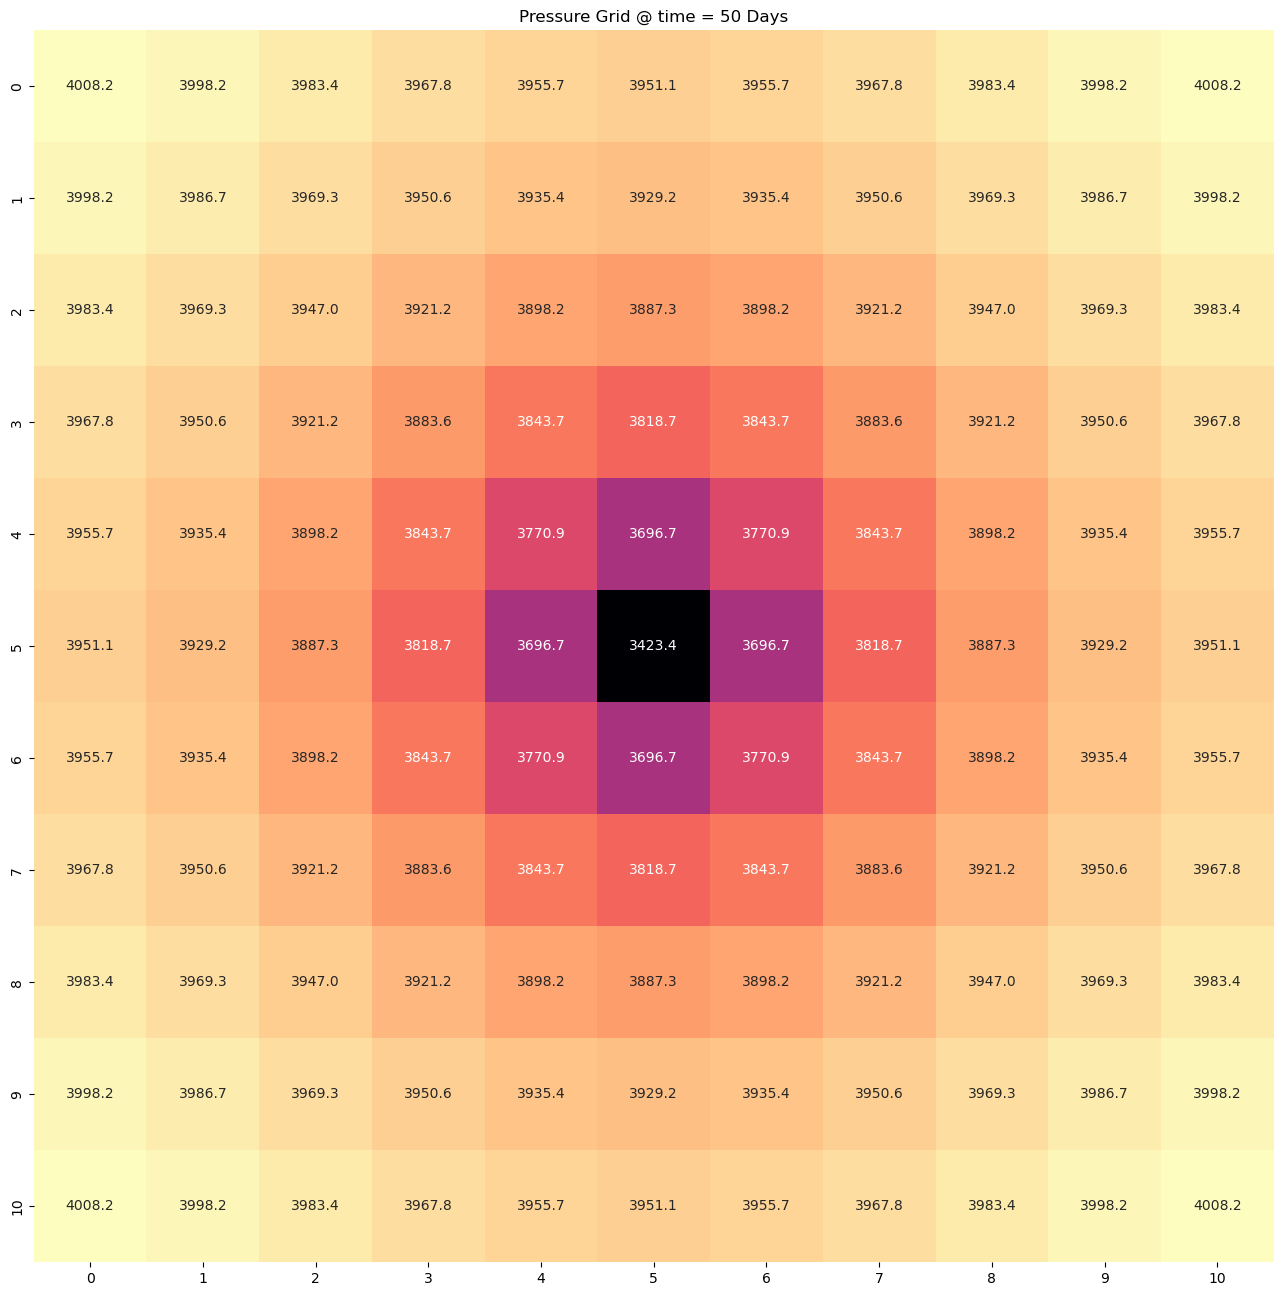

In [193]:
labels = [i+1 for i in range(len(ijpy_m))]
labels = np.reshape(labels, (ndy, ndx))
time = 50
labels = pressure_grid[:,:,time].reshape(ndy, ndx)
plt.figure(figsize=(16,16))
ax = sns.heatmap(pressure_grid[:,:,time].swapaxes(0, 1), cmap="magma", cbar=False, annot=True, fmt='.1f')
ax.set()
ax.set_title(f'Pressure Grid @ time = {time*dt} Days')
plt.show()


Text(0.5, 0, 'Time (days)')

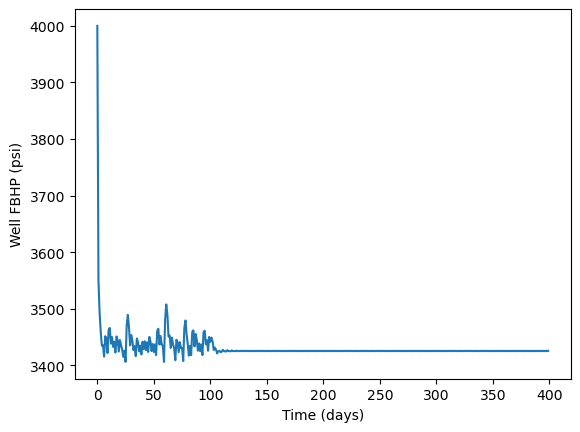

In [194]:
plt.plot(pressure_grid[5,5,:])
plt.ylabel('Well FBHP (psi)')
plt.xlabel('Time (days)')

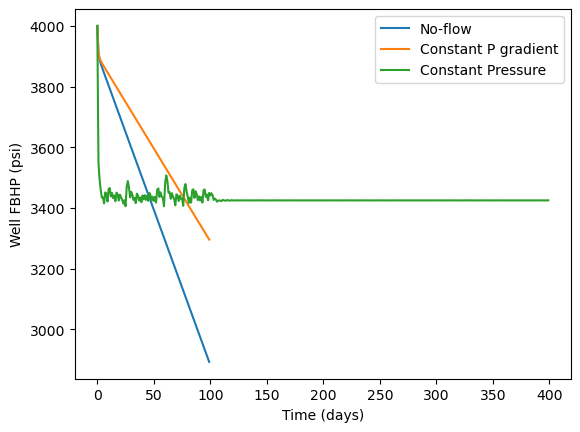

In [197]:
plt.plot(noflow_pgrid[5,5,:])
plt.plot(cpg_pgrid[5,5,:])
plt.plot(cp_pgrid[5,5,:])

plt.ylabel('Well FBHP (psi)')
plt.xlabel('Time (days)')
plt.legend(['No-flow', 'Constant P gradient', 'Constant Pressure'])